In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from train import train_fidelity, train_base, train_gradreg, train_gen, train_locality
from models.mnist_cnn import CNN3b, CNN4b
from loaders.mnist_loader import MNIST_data
from torch.optim import Adam, Adadelta
from losses.losses import FidelityConstraint, StandardCrossEntropy, GradientRegularization, GeneralizabilityConstraint
from metrics.metrics import accuracy, MoRF
from torch.nn import Softmax 
from captum.attr import Saliency
from torchsummary import summary

In [2]:
loaders = MNIST_data(batch_size = 60)

In [3]:
print("CUDA Available: ",torch.cuda.is_available())
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [4]:
 torch.cuda.empty_cache()

In [5]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

NVIDIA GeForce RTX 2060 with Max-Q Design
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
rmodel = CNN3b().to(device)
optimizer = Adam(rmodel.parameters())   

In [7]:
acc, loss = train_gradreg(rmodel, loaders, 8, optimizer, constraint = "grad_reg")

C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\losses\losses.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probabilities = self.log_softmax(outputs)


Epoch [1/8], Step [100/1000], Loss: 0.7682
Epoch [1/8], Step [200/1000], Loss: 0.3255
Epoch [1/8], Step [300/1000], Loss: 0.1566
Epoch [1/8], Step [400/1000], Loss: 0.1796
Epoch [1/8], Step [500/1000], Loss: 0.1491
Epoch [1/8], Step [600/1000], Loss: 0.0655
Epoch [1/8], Step [700/1000], Loss: 0.1217
Epoch [1/8], Step [800/1000], Loss: 0.1068
Epoch [1/8], Step [900/1000], Loss: 0.0866
Epoch [1/8], Step [1000/1000], Loss: 0.1030
Accuracy =  0.9260166666666667
Epoch [2/8], Step [100/1000], Loss: 0.0615
Epoch [2/8], Step [200/1000], Loss: 0.0552
Epoch [2/8], Step [300/1000], Loss: 0.1205
Epoch [2/8], Step [400/1000], Loss: 0.0492
Epoch [2/8], Step [500/1000], Loss: 0.1108
Epoch [2/8], Step [600/1000], Loss: 0.1863
Epoch [2/8], Step [700/1000], Loss: 0.1187
Epoch [2/8], Step [800/1000], Loss: 0.0491
Epoch [2/8], Step [900/1000], Loss: 0.0388
Epoch [2/8], Step [1000/1000], Loss: 0.0316
Accuracy =  0.9758833333333333
Epoch [3/8], Step [100/1000], Loss: 0.1859
Epoch [3/8], Step [200/1000], Los

In [8]:
accuracy(rmodel,loaders)

0.9869

In [13]:
bmodel = torch.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\simple_cnn_9891.pt")
bmodel.eval()

CNN3b(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=784, out_features=10, bias=True)
)

In [12]:
lmodel = torch.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\simple_cnn_loc_9717.pt")
lmodel.eval()

CNN3b(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=784, out_features=10, bias=True)
)

In [14]:
fmodel = torch.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\simple_cnn_fid_9864.pt")
fmodel.eval()

CNN3b(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=784, out_features=10, bias=True)
)

In [17]:
grad = Saliency(fmodel)
grad1 = Saliency(bmodel)
grad2 = Saliency(lmodel)
grad3 = Saliency(rmodel)


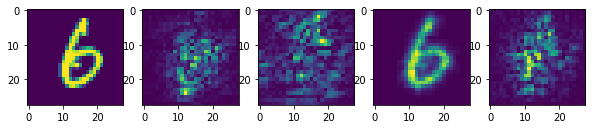

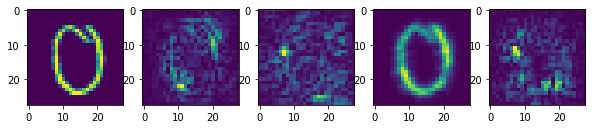

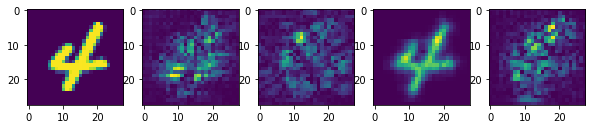

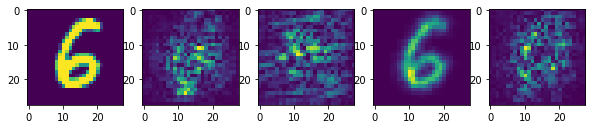

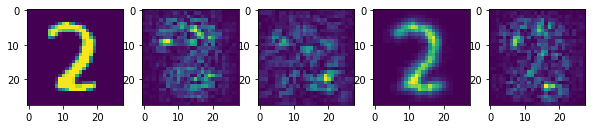

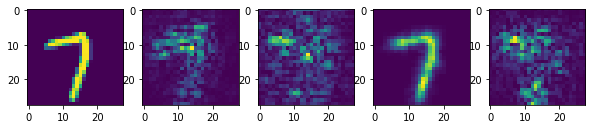

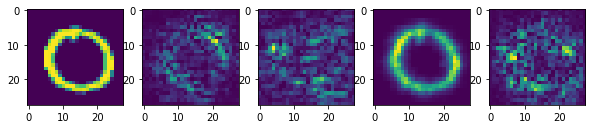

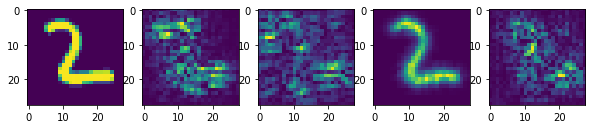

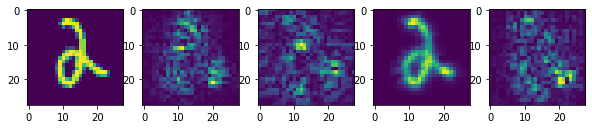

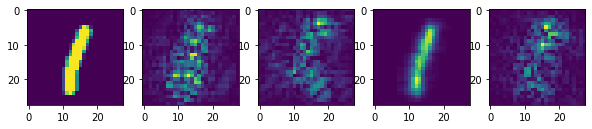

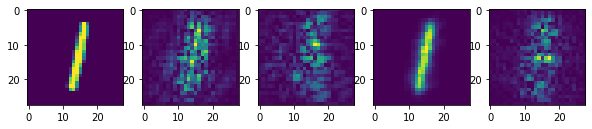

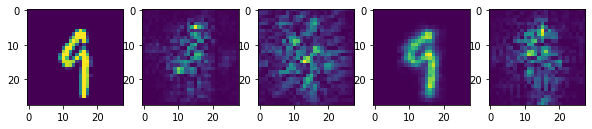

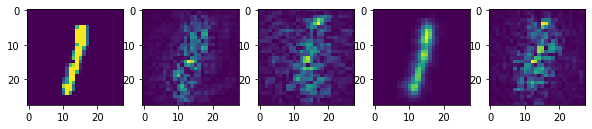

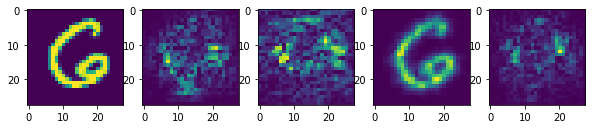

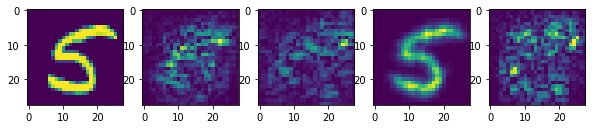

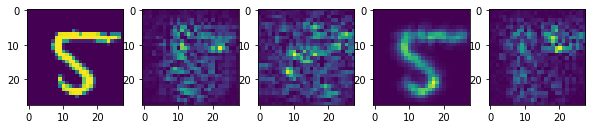

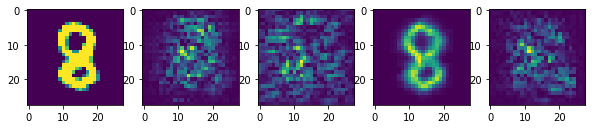

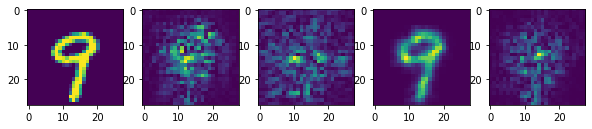

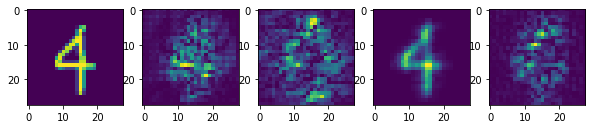

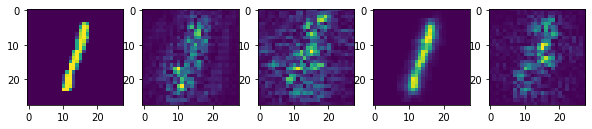

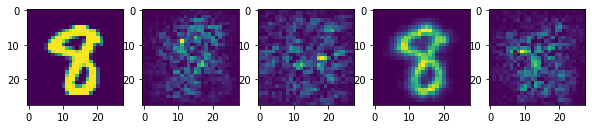

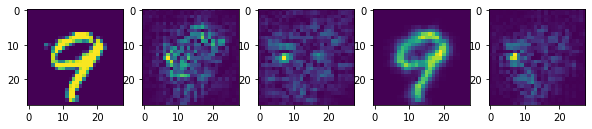

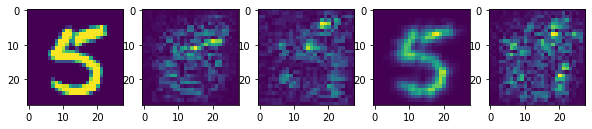

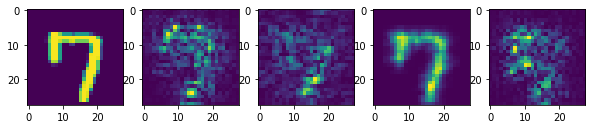

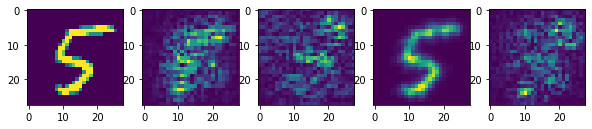

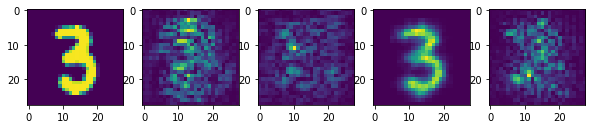

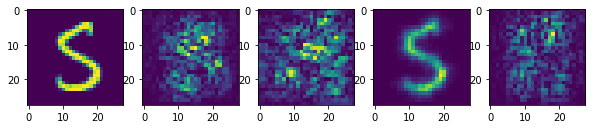

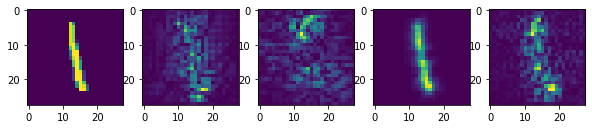

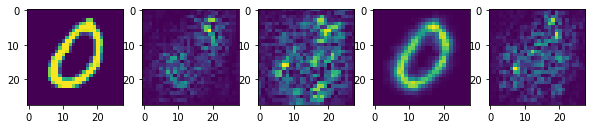

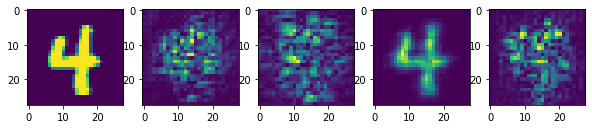

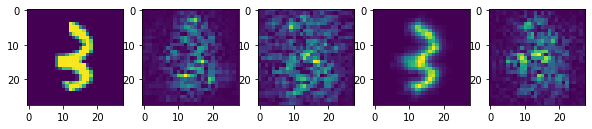

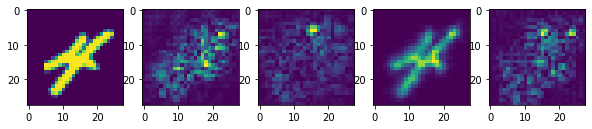

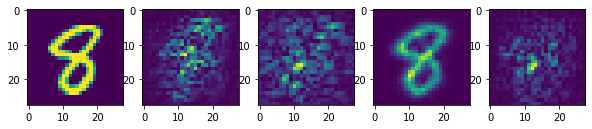

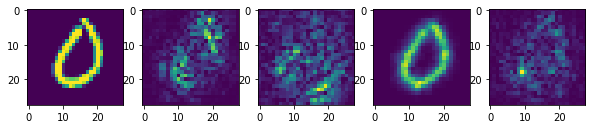

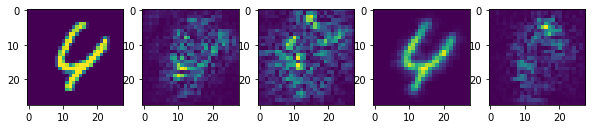

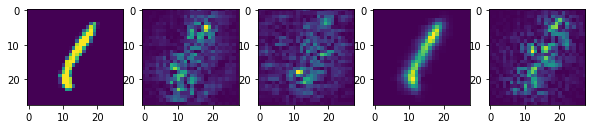

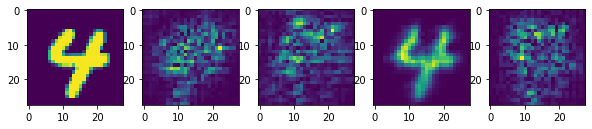

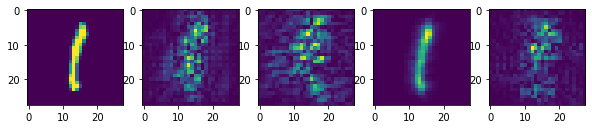

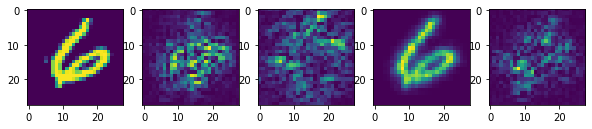

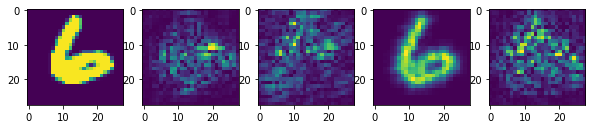

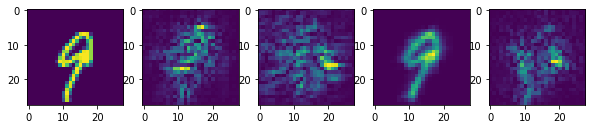

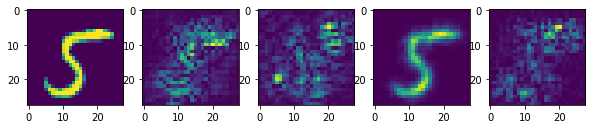

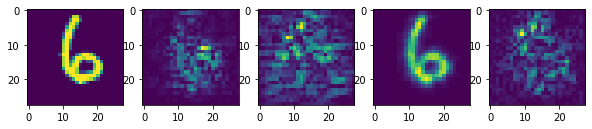

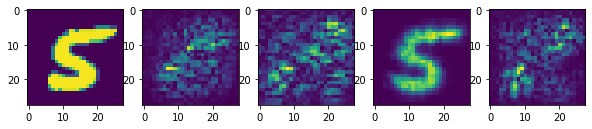

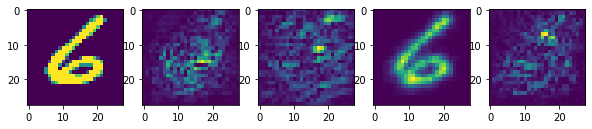

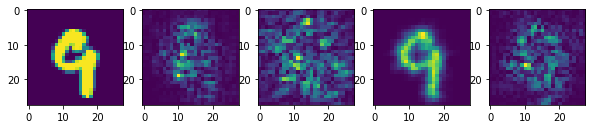

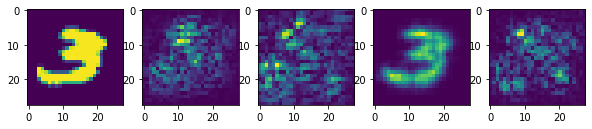

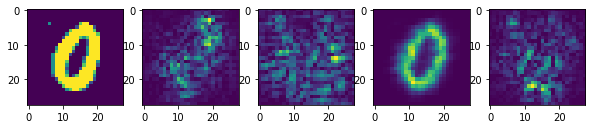

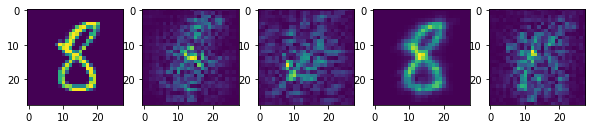

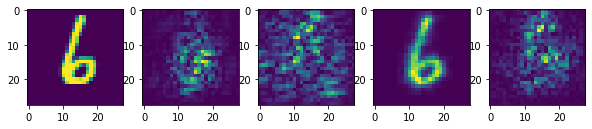

In [18]:
sample = iter(loaders['test'])
imgs = []
lbls = []


for i in range(50):
    img, lbl = next(sample)
    img = img.to(device)
    lbl = lbl.to(device)
    
    attr = grad.attribute(img, target=lbl.item())
    attr = attr.squeeze()
    attr1 = grad1.attribute(img, target=lbl.item())
    attr1 = attr1.squeeze()
    attr2 = grad2.attribute(img, target=lbl.item())
    attr2 = attr2.squeeze()
    attr3 = grad3.attribute(img, target=lbl.item())
    attr3 = attr3.squeeze()
   
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(2,5,1)
    ax1.imshow(img.squeeze().cpu().numpy())
    ax2 = fig.add_subplot(2,5,2)
    ax2.imshow(attr.squeeze().cpu().numpy())
    ax3 = fig.add_subplot(2,5,3)
    ax3.imshow(attr1.squeeze().cpu().numpy())
    ax4 = fig.add_subplot(2,5,4)
    ax4.imshow(attr2.squeeze().cpu().numpy())
    ax5 = fig.add_subplot(2,5,5)
    ax5.imshow(attr3.squeeze().cpu().numpy())
    plt.show()
    

In [10]:
accuracy(gmodel,loaders)

0.9871

In [11]:
torch.save(gmodel, r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\3b_cnn_adam_gen_9871.pt")

In [8]:
accuracy(fmodel,loaders)

0.9894

In [19]:
accuracy(bmodel,loaders)

0.9906

In [13]:
accuracy(gmodel,loaders)

0.9877

In [19]:
accuracy(bmodel1,loaders)

0.9881

In [20]:
#torch.save(bmodel1, r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\4b_cnn_adadelta_9881.pt")

In [7]:
model0 = torch.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\3b_cnn_adam_fid_9882.pt")
model0.eval()

CNN3b(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [4]:
model1 = torch.load(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\\4b_cnn_adadelta_fid_9518.pt")
model1.eval()

CNN4b(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dense1): Sequential(
    (0): Linear(in_features=16384, out_features=128, bias=True)
  )
  (dense2): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [9]:
x = []
y = []

for images, labels in loaders['train']:
    x.append(images)
    y.append(labels)

In [10]:
x[0].shape

torch.Size([60, 1, 28, 28])

In [15]:
torch.argmax(Softmax()(model1(x[0].to(device))), dim=1)

C:\Users\unknown\Anaconda3\envs\xai4uc3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([1, 8, 8, 9, 7, 4, 6, 9, 0, 0, 0, 7, 0, 5, 7, 4, 3, 3, 3, 3, 6, 2, 7, 1,
        2, 6, 6, 9, 3, 4, 6, 5, 9, 6, 0, 3, 9, 4, 4, 1, 8, 5, 6, 1, 5, 2, 2, 9,
        8, 6, 7, 1, 4, 0, 9, 7, 6, 0, 4, 1], device='cuda:0')

In [27]:
for n in range(10):
    print()

C:\Users\unknown\Anaconda3\envs\xai4uc3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


torch.Size([7, 1, 28, 28])
torch.Size([6, 1, 28, 28])
torch.Size([4, 1, 28, 28])
torch.Size([6, 1, 28, 28])
torch.Size([7, 1, 28, 28])
torch.Size([4, 1, 28, 28])
torch.Size([9, 1, 28, 28])
torch.Size([6, 1, 28, 28])
torch.Size([4, 1, 28, 28])
torch.Size([7, 1, 28, 28])


In [25]:
for i in [0,1,2,3]:
    for j in range((i+1),4):
        

i =  0
1
2
3
i =  1
2
3
i =  2
3
i =  3


In [13]:
accuracy(model0,loaders)

0.9684

In [11]:
accuracy(model1,loaders)

0.9518

In [21]:
perc = list(sorted(np.linspace(0, 100, num=20).astype(int), reverse=True))

In [31]:
drop0 = MoRF(model0, loaders, perc)

C:\Users\unknown\Anaconda3\envs\xai4uc3\lib\site-packages\captum\_utils\gradient.py:58: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\metrics\metrics.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  d = softm(model(images.cuda()*maskpos.cuda())).cpu().detach().numpy()[0,torch.argmax(softm(model(images.cuda())))]/torch.max(softm(model(images.cuda()))).cpu().detach().numpy()


In [32]:
drop1 = MoRF(model1, loaders, perc)

In [27]:
bdrop0

array([1.        , 0.9961991 , 0.9939671 , 0.99067806, 0.98420988,
       0.9780885 , 0.9700118 , 0.96019138, 0.94048305, 0.9192363 ,
       0.88569709, 0.84696926, 0.78146375, 0.71755237, 0.6442615 ,
       0.56283756, 0.46812199, 0.3835839 , 0.3055036 , 0.23282925])

In [18]:
1-drop1

array([0.        , 0.29093052, 0.52430298, 0.64878743, 0.73880627,
       0.79103772, 0.83093271, 0.85483369, 0.87438611, 0.88347648,
       0.89230496, 0.8911447 , 0.88981796, 0.89067377, 0.89124072,
       0.89276235, 0.89346811, 0.89252203, 0.89292844, 0.89223848])

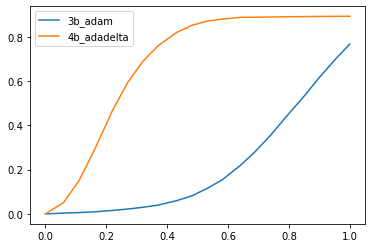

In [28]:
plt.plot(1-np.array(perc)/100, 1-bdrop0, label="3b_adam")
plt.plot(1-np.array(perc)/100, 1-bdrop1, label="4b_adadelta")
plt.legend()
plt.show()

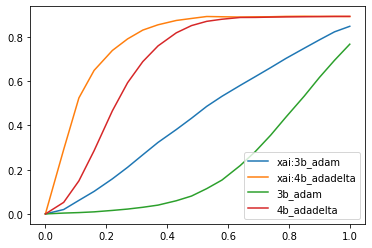

In [33]:
plt.title("MoRF curve")
plt.plot(1-np.array(perc)/100, 1-drop0, label="xai:3b_adam")
plt.plot(1-np.array(perc)/100, 1-drop1, label="xai:4b_adadelta")
plt.plot(1-np.array(perc)/100, 1-bdrop0, label="3b_adam")
plt.plot(1-np.array(perc)/100, 1-bdrop1, label="4b_adadelta")
plt.xlabel("% pix removed")
plt.ylabel("avg error")
plt.legend()
plt.savefig(r"C:\Users\unknown\Desktop\xai_projects\xai-learning-constraints\results\MoRF_curve_fidelity_3b4b.png")
plt.show()

In [38]:
np.mean(1-drop0)

0.4373033463348592

In [39]:
np.mean(1-drop1)

0.7678295304900484

In [40]:
np.mean(1-bdrop1)

0.6769576146917377

In [41]:
np.mean(1-bdrop0)

0.2219057289009787